In [ ]:
import pandas as pd
import numpy as np

# Выгрузка данных

In [ ]:
import requests

In [ ]:
SPECIALIZATION_IT = "Информационные технологии, интернет, телеком"

In [ ]:
VACANCIES_PER_PAGE = 100

API_AREAS_REQUEST = 'https://api.hh.ru/areas'
API_VACANCIES_REQUEST = 'https://api.hh.ru/vacancies'
API_SPECIALIZATIONS_REQUEST = 'https://api.hh.ru/specializations'

CURRANCY_USD = "USD"
CURRANCY_EUR = "EUR"

EXCHANGE_RATE_USD = 71
EXCHANGE_RATE_EUR = 86

TAX_RATE = 0.13

In [ ]:
COUNTRY_RUSSIA = 'Россия'

In [ ]:
COMMENT_REGION_PROCESSING_START = 'Обрабатываю регионы:'
COMMENT_REGION_PROCESSING_FINISH = 'Готово! Найдено вакансий: '
COMMENT_KEYWORD_PROCESSING_START = 'Ищу вакансии по ключевому слову '

## Получение данных

In [ ]:
def get_russian_regions():
    ''' Возвращает DataFrame регионов РФ'''
    regions = requests.get(API_AREAS_REQUEST)
    
    region_frame = pd.DataFrame(regions.json())
    
    russia_index = region_frame[region_frame['name'] == COUNTRY_RUSSIA].index.tolist()[0]
    russia_regions_frame = pd.DataFrame(region_frame['areas'][russia_index])
    
    return russia_regions_frame

In [ ]:
def get_it_specialization_index():
    ''' Возвращает id специализации "Информационные технологии, интернет, телеком"'''
    specializations = requests.get(API_SPECIALIZATIONS_REQUEST)
    specializations_frame = pd.DataFrame(specializations.json())
    it_id = specializations_frame.loc[specializations_frame['name'] == SPECIALIZATION_IT]['id'].values[0]
    it_id
    
    return it_id

In [ ]:
def get_region_vacancies_count(keyword, region, specialization_index):
    ''' Возвращает количество вакансий в регионе region, 
    найденных по ключевому слову keyword,
    со специализацией с индексом specialization_index'''    

    result = requests.get(
        API_VACANCIES_REQUEST, 
        params = {
            'text': keyword, 
            'per_page' : 1, 
            'search_field' : 'name', 
            'area': region,
            'specialization' : specialization_index
        }
    )
            
    if(result.status_code == 200):
        return int(result.json()['found'])

    return 0

In [ ]:
def get_region_vacancies(keyword, region, specialization_index, page):
    
    ''' Возвращает список вакансий в регионе region, 
    найденных по ключевому слову keyword,
    со специализацией с индексом specialization_index'''

    response = requests.get(
        API_VACANCIES_REQUEST,
        params = {
            'text': keyword, 
            'area': region, 
            'per_page' : VACANCIES_PER_PAGE, 
            'search_field' : 'name', 
            'page': page,
            'specialization' : specialization_index
            }
    )
    if(response.status_code == 200):
        found_vacancies = response.json()['items']

        return found_vacancies
    
    return None

In [ ]:
def get_vacancies_data_frame(keyword_list, region = None):
    ''' Возвращает DataFrame вакансий, найденных по ключевым словам из списка keyword_list'''
    vacancies_list = []
    
    russia_regions_frame = get_russian_regions()
    it_specialization_index = get_it_specialization_index();

    if (region is not None):
        russia_regions_list = [region]
    else: 
        russia_regions_list = [x for x in russia_regions_frame['id']]

    for keyword in [keyword_list]:
        
        print(COMMENT_KEYWORD_PROCESSING_START + keyword)
        print(COMMENT_REGION_PROCESSING_START)
            
        for region in russia_regions_list:
            found = get_region_vacancies_count(keyword, region, it_specialization_index)
            region_name = russia_regions_frame.loc[russia_regions_frame['id'] == region]['name'].values[0];
            print(region_name)
            for page in range((found // VACANCIES_PER_PAGE) + 1):
                found_vacancies = get_region_vacancies(keyword, region, it_specialization_index, page)
                found_vacancies = enrich_vacancies_list(found_vacancies, region_name)

                if (found_vacancies is not None):
                    vacancies_list = vacancies_list + found_vacancies

    print(COMMENT_REGION_PROCESSING_FINISH)
    print(len(vacancies_list))
    
    full_vacancies_frame = pd.DataFrame(vacancies_list)
    
    return full_vacancies_frame

In [ ]:
def get_vacancy(id):
    
    ''' Возвращает вакансию в виде словаря по ее id'''
    response = requests.get(API_VACANCIES_REQUEST + "/" + str(id))
    
    if(response.status_code == 200):
        return response.json()
    
    return None

In [ ]:
def enrich_vacancies_list(vacancies, region_name):
    ''' Обогащает вакансии из vacancies данными из детальной информации по каждой 
    вакансии, а также названием региона region_name'''
    for vacancy in vacancies:
        details = get_vacancy(vacancy['id'])
        vacancy['description'] = details['description']
        vacancy['experience'] = details['experience']
        vacancy['key_skills'] = details['key_skills']
    
        vacancy['region'] = region_name
    return vacancies

## Нормализация данных

In [ ]:
def normolize_employer(vacancies_frame):
    ''' Нормализует данные о работодателе '''
    normolized_vacancies_frame = vacancies_frame.copy()
    
    normalized_employer = pd.json_normalize(normolized_vacancies_frame['employer'])
    normalized_employer = normalized_employer.rename(columns={'name':'employer_name'})
    normolized_vacancies_frame = pd.concat([normolized_vacancies_frame, normalized_employer['employer_name']], axis=1)
    
    return normolized_vacancies_frame

In [ ]:
def normolize_area(vacancies_frame):
    ''' Нормализует данные о регионе '''
    normolized_vacancies_frame = vacancies_frame.copy()
    
    normalized_area = pd.json_normalize(normolized_vacancies_frame['area'])
    normalized_area = normalized_area.rename(columns={'id':'area_id','name':'area_name'})
    normolized_vacancies_frame = pd.concat([normolized_vacancies_frame, normalized_area], axis=1)
    
    return normolized_vacancies_frame

In [ ]:
def normolize_schedule(vacancies_frame):
    ''' Нормализует данные о расписании '''
    normolized_vacancies_frame = vacancies_frame.copy()

    normalized_schedule = pd.json_normalize(normolized_vacancies_frame['schedule'])
    normalized_schedule = normalized_schedule.rename(columns={'id':'schedele_id','name':'schedule_name'})
    normolized_vacancies_frame = pd.concat([normolized_vacancies_frame, normalized_schedule], axis=1)

    return normolized_vacancies_frame

In [ ]:
def calculate_salary(vacancies_frame):
    ''' Рассчитывает среднюю зарплату для каждой вакансии. 
    Если зарплата в валюте - переводит в рубли. 
    Если зарплата без учета налога - отнимает сумму налога.'''    
    vacancies_frame_with_avg_salary = vacancies_frame.copy()
    
    vacancies_frame_with_avg_salary['avg_salary'] = vacancies_frame[['salary_from', 'salary_to']].mean(axis = 'columns')
   
    vacancies_frame_with_avg_salary['avg_salary'] = np.where(vacancies_frame_with_avg_salary['salary_currency'] == "USD", 
                                                            vacancies_frame_with_avg_salary['avg_salary'] * EXCHANGE_RATE_USD, 
                                                            vacancies_frame_with_avg_salary['avg_salary'])
    
    vacancies_frame_with_avg_salary['avg_salary'] = np.where(vacancies_frame_with_avg_salary['salary_currency'] == "EUR", 
                                                           vacancies_frame_with_avg_salary['avg_salary'] * EXCHANGE_RATE_EUR, 
                                                           vacancies_frame_with_avg_salary['avg_salary'])
    
    vacancies_frame_with_avg_salary['avg_salary'] = np.where(vacancies_frame_with_avg_salary['salary_gross'] == True, 
                                                           vacancies_frame_with_avg_salary['avg_salary'] * (1 - TAX_RATE), 
                                                           vacancies_frame_with_avg_salary['avg_salary'])
    
    return vacancies_frame_with_avg_salary

In [ ]:
def normolize_salary(vacancies_frame):
    ''' Нормализует данные зарплате '''
    normolized_vacancies_frame = vacancies_frame.copy()
    
    normolized_vacancies_frame['salary'] = normolized_vacancies_frame['salary'].apply(lambda x: {} if pd.isna(x) else x)
    normalized_salary = pd.json_normalize(normolized_vacancies_frame['salary'])
    normalized_salary = normalized_salary.rename(columns =
                                                 {'from': 'salary_from',
                                                  'to': 'salary_to',
                                                  'currency':'salary_currency',
                                                  'gross':'salary_gross'
                                                 }
                                                )
    normolized_vacancies_frame = pd.concat([normolized_vacancies_frame, normalized_salary], axis=1)

    normolized_vacancies_frame = calculate_salary(normolized_vacancies_frame)
    
    return normolized_vacancies_frame

In [ ]:
def normolize_experience(vacancies_frame):
    ''' Нормализует данные о требуемом опыте '''
    normolized_vacancies_frame = vacancies_frame.copy()

    normalized_experience = pd.json_normalize(normolized_vacancies_frame['experience'])
    normalized_experience = normalized_experience.rename(columns={'id':'experience_id','name':'experience_name'})
    normolized_vacancies_frame = pd.concat([normolized_vacancies_frame, normalized_experience], axis=1)
    normolized_vacancies_frame

    return normolized_vacancies_frame

In [ ]:
def normolize_key_skills(vacancies_frame):
    ''' Нормализует список ключевых навыков '''
    def get_skills(list_of_dictionaries):
        list_of_skills = [skill['name'] for skill in list_of_dictionaries]
        return ' '.join(list_of_skills)


    normolized_vacancies_frame = vacancies_frame.copy()
    normolized_vacancies_frame['key_skills'] = normolized_vacancies_frame['key_skills'].apply(get_skills)

    return normolized_vacancies_frame

In [ ]:
def normolize_vacancies_frame(vacancies_frame):
    ''' Нормализует все поля датафрейма, нужные для анализа '''
    normolized_vacancies_frame = vacancies_frame.copy()
    
    normolized_vacancies_frame = normolize_employer(normolized_vacancies_frame)
    normolized_vacancies_frame = normolize_area(normolized_vacancies_frame)
    normolized_vacancies_frame = normolize_schedule(normolized_vacancies_frame)
    normolized_vacancies_frame = normolize_salary(normolized_vacancies_frame)
    normolized_vacancies_frame = normolize_experience(normolized_vacancies_frame)
    normolized_vacancies_frame = normolize_key_skills(normolized_vacancies_frame)
    
    return normolized_vacancies_frame 

In [ ]:
def filter_vacancies_frame(vacancies_frame):
    ''' Фильтрует датафрейм, оставляя только нужные для анализа столбцы '''
    filtered = vacancies_frame[['id', 'name', 'employer_name', 'region', 'area_name', 'schedule_name', 'avg_salary', 'description', 'key_skills', 'experience_name']]
    
    return filtered

# Определение грейдов

In [ ]:
import re

In [ ]:
JUNIOR_GRADE = "junior"
MIDDLE_GRADE = "middle"
SENIOR_GRADE = "senior"
ARCHITECT_GRADE = "architect"
TEAM_LEAD_GRADE = "team lead"
NOT_DEFINED = "not defined"
NOT_FOUND = "not found"
VACANCY_CONTAINS_GRADE_KEYWORDS = "+"
VACANCY_NOT_CONTAINS_GRADE_KEYWORDS = "-"

KEYWOORD_JUNIOR_1 = "junior"
KEYWOORD_JUNIOR_2 = "младш"
KEYWOORD_MIDDLE_1 = "middle"
KEYWOORD_MIDDLE_2 = "старш"
KEYWOORD_SENIOR_1 = "senior"
KEYWOORD_SENIOR_2 = "ведущ"
KEYWOORD_ARCHITECT_1 = "architect"
KEYWOORD_ARCHITECT_2 = "архитектор"
KEYWOORD_LEAD_1 = "lead"
KEYWOORD_LEAD_2 = "руководит"

In [ ]:
def get_grades(name):
    ''' Определяет набор грейдов по наименованию name. Если найдено несколько грейдов, то результат будет строкой,
    содержащей все эти грейды через "/". Если грейд не определен, вернется "not defined"'''
    result_grade = None

    if (re.search(KEYWOORD_JUNIOR_1, name, re.IGNORECASE) or 
        re.search(KEYWOORD_JUNIOR_2, name, re.IGNORECASE)):
        result_grade = JUNIOR_GRADE

    if (re.search(KEYWOORD_MIDDLE_1, name, re.IGNORECASE) or 
          re.search(KEYWOORD_MIDDLE_2, name, re.IGNORECASE)):
        if result_grade is None:
            result_grade = MIDDLE_GRADE
        else:
            result_grade = result_grade + '/' + MIDDLE_GRADE
    
    if (re.search(KEYWOORD_SENIOR_1, name, re.IGNORECASE) or 
        re.search(KEYWOORD_SENIOR_2, name, re.IGNORECASE)):
        if result_grade is None:
            result_grade = SENIOR_GRADE
        else:
            result_grade = result_grade + '/' + SENIOR_GRADE
    
    if (re.search(KEYWOORD_ARCHITECT_1, name, re.IGNORECASE) or 
          re.search(KEYWOORD_ARCHITECT_2, name, re.IGNORECASE)):
        if result_grade is None:
            result_grade = ARCHITECT_GRADE
        else:
            result_grade = result_grade + '/' + ARCHITECT_GRADE
            
    if (re.search(KEYWOORD_LEAD_1, name, re.IGNORECASE) or 
          re.search(KEYWOORD_LEAD_2, name, re.IGNORECASE)):
        if result_grade is None:
            result_grade = TEAM_LEAD_GRADE
        else:
            result_grade = result_grade + '/' + TEAM_LEAD_GRADE 

    if result_grade is None:
        return NOT_DEFINED
    else:
        return result_grade

In [ ]:
def fill_grades(vacancies_frame):
    
    filled_grade_vacancies_frame = vacancies_frame.copy() 
    
    filled_grade_vacancies_frame['grade'] = filled_grade_vacancies_frame['name'].apply(get_grades)
    
    return filled_grade_vacancies_frame

# Выгрузка и сохранение данных - java

In [ ]:
import pickle

In [ ]:
SEARCH_KEYWORD_JAVA_DEVELOPER_1 = 'java'

In [ ]:
def get_vacancies_java():
    ''' Выгружает вакансии с api по списку ключевых слов, нормализует и фильтрует полученные данные '''
    vacancies_data_frame = get_vacancies_data_frame(SEARCH_KEYWORD_JAVA_DEVELOPER_1) 
    
    vacancies_data_frame = normolize_vacancies_frame(vacancies_data_frame)
    vacancies_data_frame = filter_vacancies_frame(vacancies_data_frame)
    
    return vacancies_data_frame

In [ ]:
# Выгружаем данные и сохраняем их в pickle, чтобы потом использовать
df = get_vacancies_java()

with open('hh_java.pickle', 'wb') as f:
    pickle.dump(df, f)

NameError: ignored

# Экспорт

In [ ]:
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import Workbook

In [ ]:
COMMENT_EXPORT_COMPLETED = 'Результаты можно посмотреть в файле '

In [ ]:
def export_vacancies(vacancies_frame, file_name):
    ''' Экспортирует vacancies_frame в файле excel '''
    wb = Workbook()
    ws = wb.active
    
    for r in dataframe_to_rows(vacancies_frame, index=True, header=True):
        ws.append(r)
        
    for cell in ws['A'] + ws[1]:
        cell.style = 'Pandas'
        
    wb.save(file_name)
    print(COMMENT_EXPORT_COMPLETED + file_name + "\'")

# Обработка текста

In [ ]:
import nltk

nltk.download('all')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup

In [ ]:
def process_text(text):
    """Принимает на вход предложение и возвращает леммы токенов предложения, фильтруя по стоп словам и удаляя знаки пунктуации"""        
    
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    words = word_tokenize(text) # С помощью токенизации разбиваем текст на токены 
    
    eng_stop_words = set(stopwords.words("english"))
    ru_stop_words = set(stopwords.words("russian"))
    
    words = [word for word in words if word not in eng_stop_words] # Удаляем стопслова  
    words = [word for word in words if word not in ru_stop_words]

    punctuations = list(string.punctuation)
    punctuations.extend(['•', '—', '–', '«', '»', "'", '``', '“', '”', '.', '’', '·', '●'])
    words = [word for word in words if word not in punctuations] # Удаляем знаки пунктуации

    stemmer_en = PorterStemmer() 
    stemmer_ru = SnowballStemmer("russian")
    words = [stemmer_en.stem(word) for word in words] # стеммируем каждое слово
    words = [stemmer_ru.stem(word) for word in words]

    words = ' '.join(words) # итог - строка

    return words

In [ ]:
def get_word_counts(texts):
    wordfreq = {}

    for sentence in texts:
        
        for word in word_tokenize(sentence):
            
            if word not in wordfreq:
                wordfreq[word] = 0 
            wordfreq[word] += 1
        
    return {k:v for k,v in sorted(wordfreq.items(), key=lambda kv: kv[1], reverse=True)}

In [ ]:
def process_vacancies_text(df):
    df['key_skills_processed'] = df['key_skills'].apply(process_text)
    df['description_processed'] = df['description'].apply(process_text)

    return df

# Классификация

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def classify_vacancies(vac_with_defined_grade):
    
    X = vac_with_defined_grade[['key_skills_processed', 'description_processed', 'experience_name', 'schedule_name']].apply(' '.join, axis = 1)
    Y = vac_with_defined_grade['grade']

    train_text, test_text = train_test_split(X, test_size=0.25, random_state=42)  
    train_labels, test_labels = train_test_split(Y, test_size=0.25, random_state=42)

    word_vectorizer = CountVectorizer(min_df=9)
    word_vectorizer.fit(X)
    
    word_features = word_vectorizer.transform(X)
    train_word_features = word_vectorizer.transform(train_text)
    test_word_features = word_vectorizer.transform(test_text)

    classifier = DecisionTreeClassifier()

    classifier.fit(train_word_features, train_labels)
    pred_train = classifier.predict(train_word_features)
    pred_test = classifier.predict(test_word_features)

    score_train = f1_score(train_labels, pred_train, average = 'micro')

    score_train_cross = np.mean(cross_val_score(classifier, train_word_features, train_labels, cv=15, scoring='f1_micro'))

    score_test = f1_score(test_labels, pred_test, average = 'micro')

    return classifier, word_vectorizer, score_train, score_train_cross, score_test

# Main

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
import pickle

## Загрузка данных

In [ ]:
# Загружаем данные, которые ранее сохранили в pickle
with open('hh_java_all.pickle', 'rb') as f2:
    vac = pickle.load(f2) # load - загрузить из файла

vac

FileNotFoundError: ignored

In [ ]:
vac.info()

## Графики

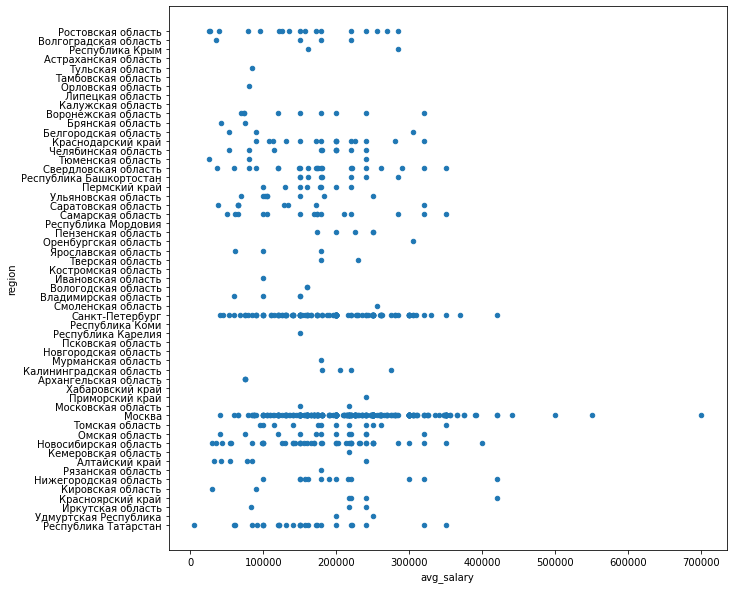

In [ ]:
vac.plot('avg_salary', 'region', kind = 'scatter', figsize =  (10, 10))

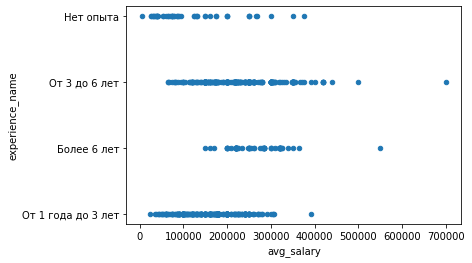

In [ ]:
vac.plot('avg_salary', 'experience_name', kind = 'scatter')

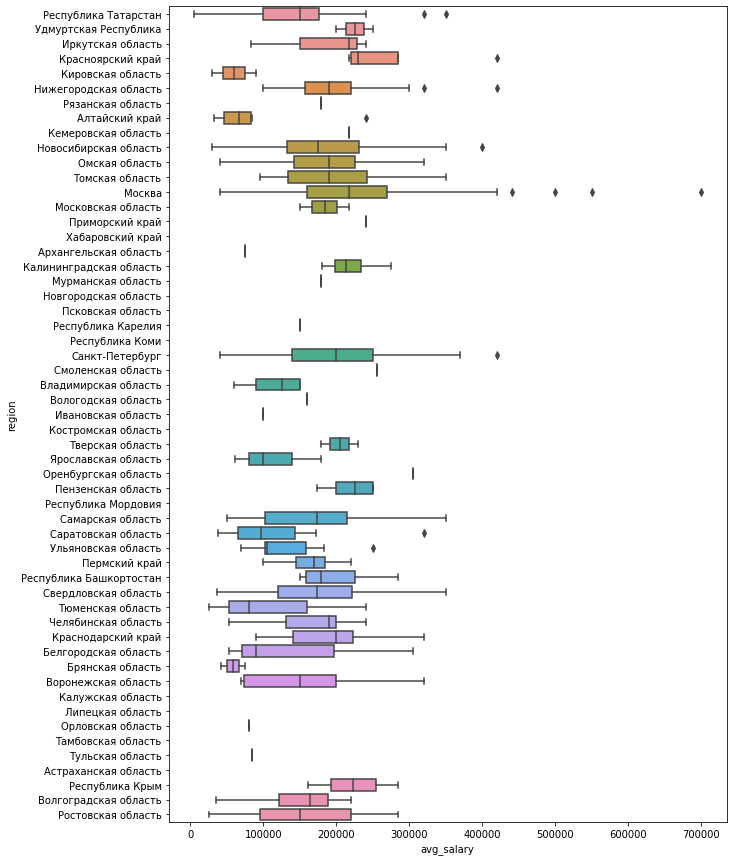

In [ ]:
f, ax = plt.subplots(figsize=(10, 15))
fig = sns.boxplot(x='avg_salary', y='region', data=vac)

## Заполнение грейдов

In [ ]:
vac = process_vacancies_text(vac)

In [ ]:
vac = fill_grades(vac)

Text(0.5, 0, 'Заработная плата')

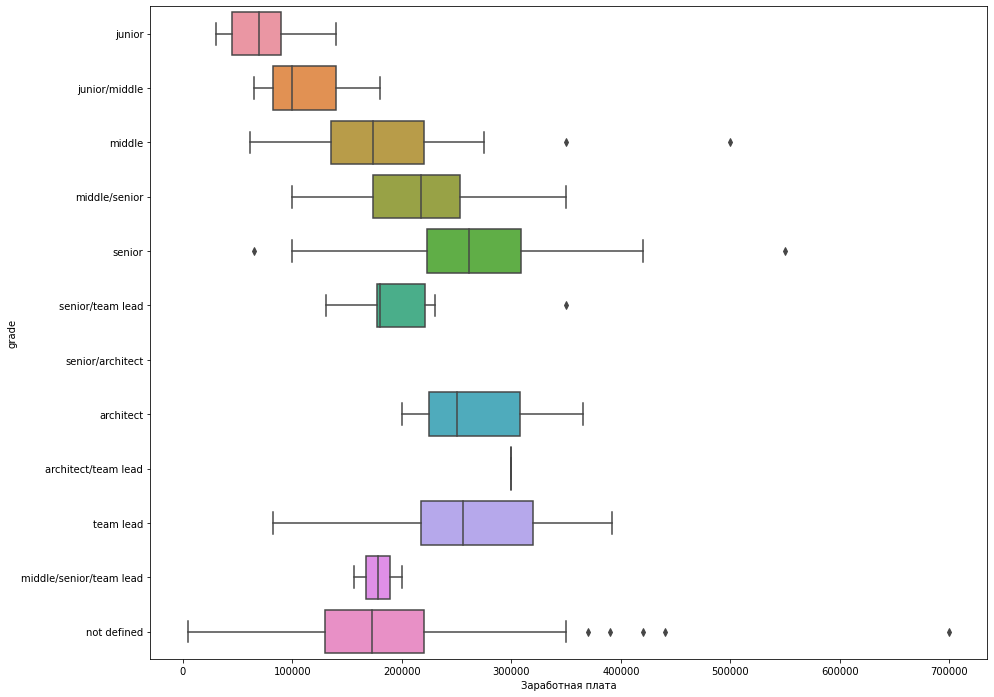

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='avg_salary', y='grade', data=vac, 
                  order = ['junior', 'junior/middle', 'middle', 'middle/senior', 'senior', 
                           'senior/team lead', 'senior/architect', 'architect', 'architect/team lead',
                           'team lead', 'middle/senior/team lead', 'not defined'])
fig.set_xlabel('Заработная плата')

### Удаление выбросов

In [ ]:
index1 = vac[vac['avg_salary'] > 450000].index
vac_filtered = vac.drop(index1)
index2 = vac_filtered[(vac_filtered['grade'] == 'senior') & (vac_filtered['avg_salary'] < 10000)].index
vac_filtered = vac_filtered.drop(index2)
index4 = vac_filtered[(vac_filtered['grade'] == 'middle') & (vac_filtered['avg_salary'] > 320000)].index
vac_filtered = vac_filtered.drop(index4)

In [ ]:
fld1=np.array(vac_filtered[vac_filtered['grade']=='junior']['avg_salary'])
fld2=np.array(vac_filtered[vac_filtered['grade']=='junior/middle']['avg_salary'])
fld3=np.array(vac_filtered[vac_filtered['grade']=='middle']['avg_salary'])
fld4=np.array(vac_filtered[vac_filtered['grade']=='middle/senior']['avg_salary'])
fld5=np.array(vac_filtered[vac_filtered['grade']=='senior']['avg_salary'])
fld6=np.array(vac_filtered[vac_filtered['grade']=='senior/team lead']['avg_salary'])
fld7=np.array(vac_filtered[vac_filtered['grade']=='architect']['avg_salary'])
fld8=np.array(vac_filtered[vac_filtered['grade']=='architect/team lead']['avg_salary'])
fld9=np.array(vac_filtered[vac_filtered['grade']=='team lead']['avg_salary'])
fld10=np.array(vac_filtered[vac_filtered['grade']=='middle/senior/team lead']['avg_salary'])

stats.mstats.kruskalwallis(fld5,fld6,fld9)

KruskalResult(statistic=4.575460747472468, pvalue=0.10149655989485065)

In [ ]:
grade_map = {'junior' : 'junior',
             'junior/middle' : 'junior', 
             'middle' : 'middle',
             'middle/senior' : 'middle/senior',
             'senior' : 'senior',
             'senior/team lead' : 'senior', 
             'architect' : 'senior',
             'architect/team lead' : 'senior', 
             'team lead' : 'senior',
             'middle/senior/team lead' : 'senior',
             'senior/architect' : 'senior',
             'not defined' : 'not defined'}
vac_filtered['grade'] = vac_filtered['grade'].map(grade_map)

Text(0.5, 0, 'Заработная плата')

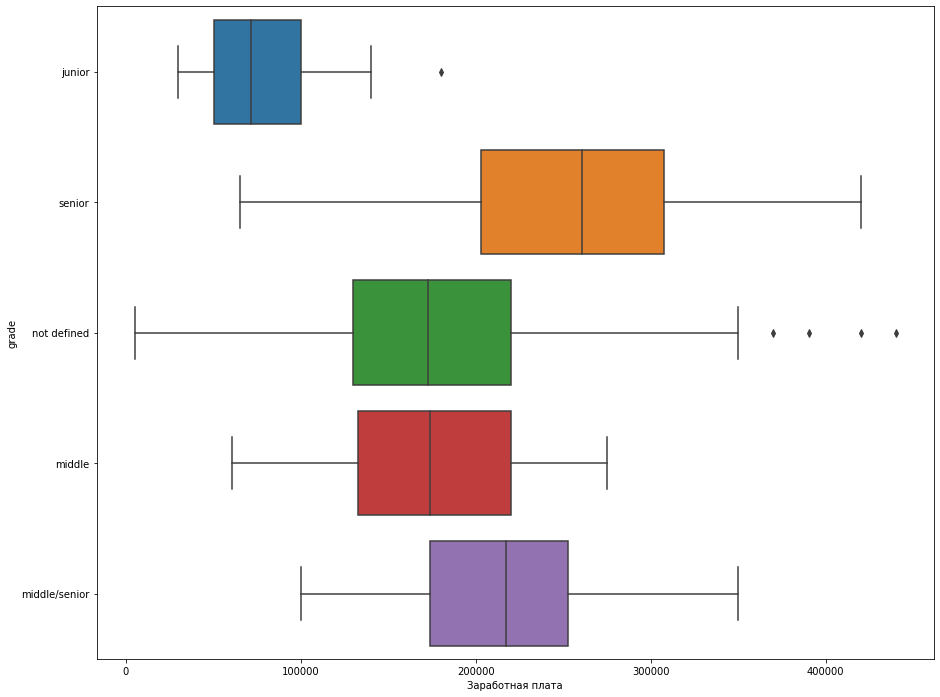

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='avg_salary', y='grade', data=vac_filtered)
fig.set_xlabel('Заработная плата')

In [ ]:
index3 = vac_filtered[(vac_filtered['grade'] == 'junior') & (vac_filtered['avg_salary'] > 160000)].index
vac_filtered = vac_filtered.drop(index3)

Text(0.5, 0, 'Заработная плата')

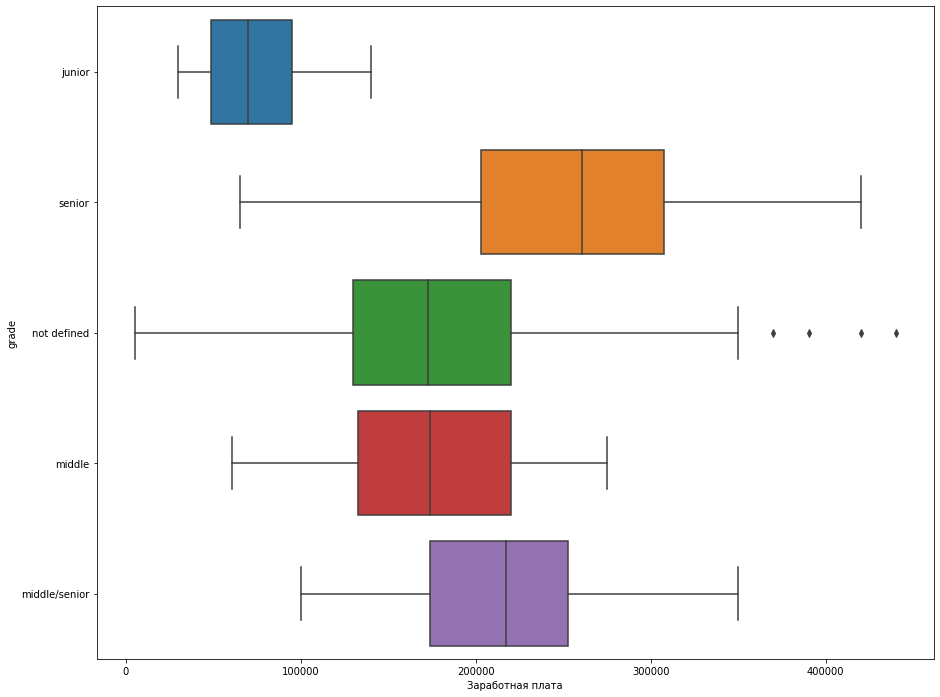

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='avg_salary', y='grade', data=vac_filtered)
fig.set_xlabel('Заработная плата')

## Классификация

In [ ]:
grade_map = {'junior': 'name', 'middle': 'name', 'middle/senior': 'name', 'senior': 'name', 'not defined':'description'}
vac_filtered['grade_source'] = vac_filtered['grade'].map(grade_map)

In [ ]:
vac_with_defined_grade = vac_filtered[vac_filtered['grade'] != 'not defined']
vac_with_not_defined_grade = vac_filtered[vac_filtered['grade'] == 'not defined']

In [ ]:
len(vac_with_not_defined_grade)

1775

In [ ]:
vac_with_defined_grade

,id,name,employer_name,region,area_name,schedule_name,avg_salary,description,key_skills,experience_name,key_skills_processed,description_processed,grade,grade_source
0,45862548,Java Developer Junior,Ай-Новус,Республика Татарстан,Казань,Полный день,NaN,<p><strong>Компания «Ай-Новус» реализует компл...,Java SQL PostgreSQL Spring Framework Java EE S...,От 1 года до 3 лет,jav sql postgresql spring framework jav EE svn...,компан ай-новус реализ комплексн ит-проект рег...,junior,name
1,46122745,Senior Java / Kotlin Developer,Солантек,Республика Татарстан,Казань,Удаленная работа,320000.0,<p>В компании <strong>Solanteq</strong> мы раз...,Java Spring Framework Back-end Unit Testing,Более 6 лет,jav spring framework back-end un test,в компан solanteq разрабатыва продукт реша зад...,senior,name
3,45918673,Java-разработчик (junior),Бэнкс Софт Системс,Республика Татарстан,Казань,Полный день,NaN,<p><strong>Banks Soft Systems – </strong>росси...,Java ООП,Нет опыта,jav ооп,bank soft syst российск разработчик комплексн ...,junior,name
15,45228004,Java Team Lead,КАЗАНЬЭКСПРЕСС ФУЛФИЛМЕНТ,Республика Татарстан,Казань,Полный день,174000.0,"<p>Люди — это фундамент KazanExpress, на котор...",PostgreSQL Spring Framework Git Java Apache Ma...,От 3 до 6 лет,postgresql spring framework git jav apach mav ...,люд эт фундамент kazanexpress котор сто компан...,senior,name
17,43238052,Java Developer Middle,Ай-Новус,Республика Татарстан,Казань,Полный день,60900.0,<p><strong>Компания «Ай-Новус» реализует компл...,Java JavaScript HTML Spring Framework Git Java...,От 1 года до 3 лет,jav javascript html spring framework git jav S...,компан ай-новус реализ комплексн ит-проект рег...,middle,name
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,44107627,Ведущий Java-разработчик,"Иннотех, Группа компаний",Ростовская область,Ростов-на-Дону,Удаленная работа,NaN,<p>Мы ищем <strong>Ведущего Java-разработчика<...,Управление проектами SQL Разработка технически...,От 3 до 6 лет,управлен проект sql разработк техническ задан ...,мы ищ ведущ jава-разработчик масштабн проект р...,senior,name
3224,45614989,Middle Java/Kotlin Developer,Тинькофф,Ростовская область,Ростов-на-Дону,Полный день,NaN,<p>Сейчас мы развиваем несколько сервисов в ра...,,От 1 года до 3 лет,,сейчас развива нескольк сервис разн департамен...,middle,name
3225,45753770,Team Lead Java / Руководитель группы разработч...,Bell Integrator,Ростовская область,Ростов-на-Дону,Удаленная работа,NaN,<p>Участие в проектах для дочернего подразделе...,Java Spring Kafka Микросервисы Team Lead Руков...,От 3 до 6 лет,jav spring kafk микросервис te lead руководите...,участ проект дочерн подразделен крупн reta сет...,senior,name
3235,45567884,Java Tech Lead,CSI (Кристалл Сервис Интеграция),Ростовская область,Ростов-на-Дону,Гибкий график,NaN,<p><strong>СОЗДАВАЙТЕ ПРОДУКТ ДЛЯ МИЛЛИОНОВ</s...,Java Java EE Apache Kafka Лидерство PostgreSQL...,От 3 до 6 лет,jav jav EE apach kafk лидерств postgresql spri...,создава продукт для миллион мы продуктов компа...,senior,name


In [ ]:
classifier, word_vectorizer, score_train, score_train_cross, score_test = classify_vacancies(vac_with_defined_grade)

In [ ]:
print('f1 score (train) = ' + str(score_train))
print('f1 cross score (train) = ' + str(score_train_cross))
print('f1 score (test) = ' + str(score_test))

f1 score (train) = 0.9990850869167429
f1 cross score (train) = 0.6860984271943175
f1 score (test) = 0.6986301369863014


In [ ]:
X = vac_with_not_defined_grade[['key_skills_processed', 'description_processed', 'experience_name', 'schedule_name']].apply(' '.join, axis = 1)
not_defined_features = word_vectorizer.transform(X)

pred_not_defined = classifier.predict(not_defined_features)

vac_with_emulated_grade = pd.DataFrame(vac_with_not_defined_grade)
vac_with_emulated_grade['grade'] = pred_not_defined
vac_with_emulated_grade

,id,name,employer_name,region,area_name,schedule_name,avg_salary,description,key_skills,experience_name,key_skills_processed,description_processed,grade,grade_source
2,46099831,Java Developer,Piano,Республика Татарстан,Казань,Полный день,150000.0,<p>Piano - это быстро растущая SaaS компания с...,Git Английский язык Java Hibernate ORM SQL,От 3 до 6 лет,git английск язык jav hibern orm sql,pia эт быстр растущ sa компан 10 офис всем мир...,senior,description
4,45950699,Java-программист,АйТиБрик,Республика Татарстан,Казань,Полный день,91350.0,<p>Привет! Мы - IT Brick. Разрабатываем веб-се...,SQL Java Java EE JavaScript HTML PostgreSQL Sp...,От 1 года до 3 лет,sql jav jav EE javascript html postgresql spri...,привет мы IT brick разрабатыва веб-сервис моби...,middle/senior,description
5,45797670,Java-разработчик,ЛП Технологии,Республика Татарстан,Иннополис,Удаленная работа,200000.0,"<p>Облачная платформа, партнер Huawei, Nvidia,...",Git Spring Framework SQL Atlassian Jira,От 3 до 6 лет,git spring framework sql atlassia jir,облачн платформ партнер huaw nvid мтс мегафон ...,senior,description
6,46066601,Java Инженер-программист,CloudAlly a Zix company,Республика Татарстан,Казань,Удаленная работа,121800.0,<p>Компания <strong>CloudAlly </strong>была ос...,Java Git NoSQL Linux Apache Maven Amazon Web S...,От 1 года до 3 лет,jav git nosql linux apach mav amazon web servi...,компан clouda основа 2011 год одн перв мир слу...,junior,description
7,46006337,Java Developer (Remote),SSP SOFTWARE,Республика Татарстан,Казань,Удаленная работа,350000.0,<p><strong>Проект</strong>: Разработка програм...,Java Spring Framework,От 3 до 6 лет,jav spring framework,проект разработк программн сервис рамк проект ...,senior,description
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,45751219,Java-разработчик,АйТи Консалт,Ростовская область,Новочеркасск,Полный день,NaN,<p>Международная компания <em><strong>ProgForc...,Java Spring Framework Java EE Hibernate ORM Mo...,От 1 года до 3 лет,jav spring framework jav EE hibern orm mongodb...,международн компан progforc россия/израиль/сш ...,senior,description
3232,43261069,Java Developer,Umbrella IT,Ростовская область,Ростов-на-Дону,Полный день,NaN,<p><strong>Umbrella IT – лучший работодатель п...,Git Java Spring Framework Maven SQL Docker,От 1 года до 3 лет,git jav spring framework mav sql docker,umbrell IT лучш работодател верс headhunt сред...,middle,description
3233,45732889,Лидер направления Java Developer,Сбербанк,Ростовская область,Ростов-на-Дону,Полный день,NaN,<p>Возможность стать лидером профессиональной ...,,От 3 до 6 лет,,возможн стат лидер профессиональн динамичн ком...,senior,description
3234,44547066,Программист Java,Телеофис,Ростовская область,Ростов-на-Дону,Удаленная работа,NaN,<p>В <strong>TELEOFIS</strong> мы занимаемся р...,Java Spring Framework HTML CSS TCP/IP,От 1 года до 3 лет,jav spring framework html css tcp/ip,в teleof занима разработк производств беспрово...,senior,description


In [ ]:
vac_with_salary_grade = vac_with_defined_grade[vac_with_defined_grade['avg_salary'].notnull()]
vac_with_salary_emulated_grade = vac_with_emulated_grade[vac_with_emulated_grade['avg_salary'].notnull()]

In [ ]:
len(vac_with_salary_emulated_grade)

377

## Медианы, средние

**С указанным грейдом**

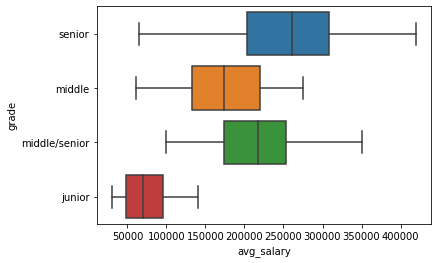

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=vac_with_salary_grade)

In [ ]:
vac_with_salary_grade.groupby('grade')['avg_salary'].mean()

grade
junior            73420.967742
middle           174424.746835
middle/senior    217063.839286
senior           259654.012346
Name: avg_salary, dtype: float64

In [ ]:
vac_with_salary_grade.groupby('grade')['avg_salary'].median()

grade
junior            69600.0
middle           174000.0
middle/senior    217500.0
senior           260500.0
Name: avg_salary, dtype: float64

**С автоматически определенным грейдом**

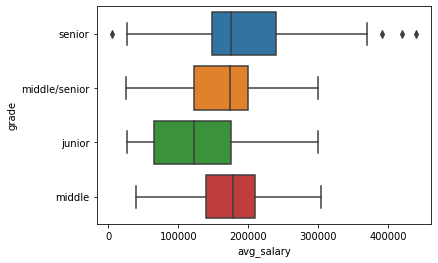

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=vac_with_salary_emulated_grade)

In [ ]:
index1 = vac_with_salary_emulated_grade[(vac_with_salary_emulated_grade['grade'] == 'middle') & (vac_with_salary_emulated_grade['avg_salary'] > 330000)].index
vac_with_salary_emulated_grade = vac_with_salary_emulated_grade.drop(index1)

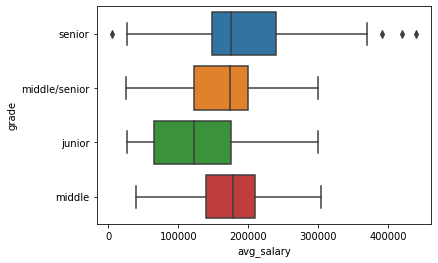

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=vac_with_salary_emulated_grade)

In [ ]:
index1 = vac_with_salary_emulated_grade[(vac_with_salary_emulated_grade['grade'] == 'middle') & (vac_with_salary_emulated_grade['avg_salary'] < 70000)].index
vac_with_salary_emulated_grade = vac_with_salary_emulated_grade.drop(index1)

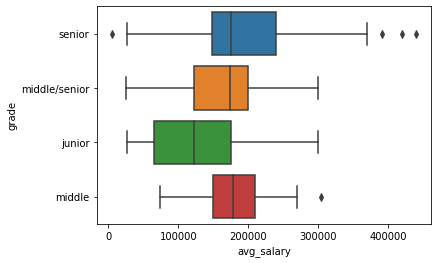

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=vac_with_salary_emulated_grade)

In [ ]:
vac_with_salary_emulated_grade.groupby('grade')['avg_salary'].mean()

grade
junior           129326.555556
middle           174676.681818
middle/senior    164540.878049
senior           190581.313158
Name: avg_salary, dtype: float64

In [ ]:
vac_with_salary_emulated_grade.groupby('grade')['avg_salary'].median()

grade
junior           121800.0
middle           178800.0
middle/senior    174000.0
senior           175000.0
Name: avg_salary, dtype: float64

**По всей выборке**

In [ ]:
all_vacancies = pd.concat([vac_with_salary_emulated_grade, vac_with_salary_grade])

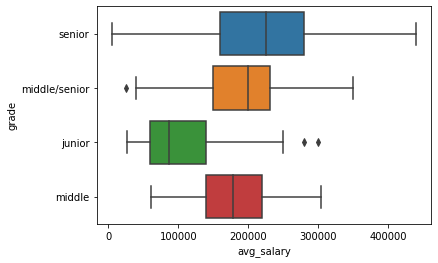

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=all_vacancies)

In [ ]:
index1 = all_vacancies[(all_vacancies['grade'] == 'junior') & (all_vacancies['avg_salary'] > 270000)].index
all_vacancies = all_vacancies.drop(index1)

In [ ]:
index1 = all_vacancies[(all_vacancies['grade'] == 'middle/senior') & (all_vacancies['avg_salary'] < 40000)].index
all_vacancies = all_vacancies.drop(index1)

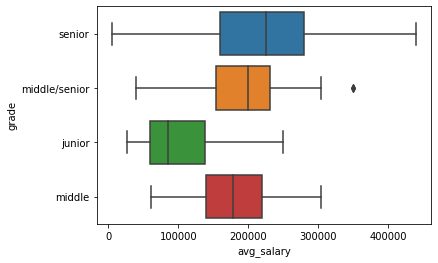

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=all_vacancies)

In [ ]:
index1 = all_vacancies[(all_vacancies['grade'] == 'middle/senior') & (all_vacancies['avg_salary'] < 43000)].index
all_vacancies = all_vacancies.drop(index1)

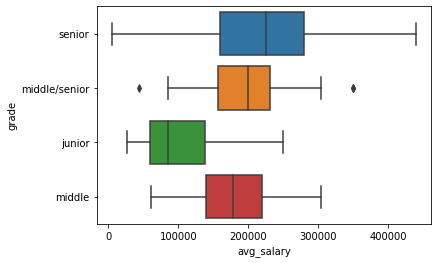

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=all_vacancies)

In [ ]:
index1 = all_vacancies[(all_vacancies['grade'] == 'middle/senior') & (all_vacancies['avg_salary'] < 50000)].index
all_vacancies = all_vacancies.drop(index1)

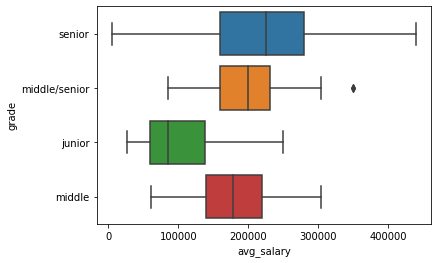

In [ ]:
fig = sns.boxplot(x='avg_salary', y='grade', data=all_vacancies)

In [ ]:
all_vacancies.groupby('grade')['avg_salary'].mean()

grade
junior           101564.121622
middle           174564.867978
middle/senior    199928.202128
senior           222370.453125
Name: avg_salary, dtype: float64

In [ ]:
all_vacancies.groupby('grade')['avg_salary'].median()

grade
junior            86000.0
middle           178800.0
middle/senior    200000.0
senior           225000.0
Name: avg_salary, dtype: float64

In [ ]:
all_vacancies.groupby('region')['avg_salary'].max()

region
Алтайский край             240000.0
Архангельская область       75000.0
Белгородская область       304500.0
Брянская область            75000.0
Владимирская область       150000.0
Волгоградская область      220000.0
Вологодская область        160000.0
Воронежская область        320000.0
Ивановская область         100000.0
Иркутская область          240000.0
Калининградская область    275000.0
Кемеровская область        217500.0
Кировская область           90000.0
Краснодарский край         319500.0
Красноярский край          420000.0
Москва                     440000.0
Московская область         217500.0
Мурманская область         178800.0
Нижегородская область      420000.0
Новосибирская область      400000.0
Омская область             320000.0
Оренбургская область       304500.0
Орловская область           80000.0
Пензенская область         250000.0
Пермский край              220000.0
Приморский край            240000.0
Республика Башкортостан    285000.0
Республика Карелия   

In [ ]:
all_vacancies[all_vacancies['region'] == 'Новосибирская область']['avg_salary'].min()

30000.0

**Экспорт результатов**

In [ ]:
export_vacancies(all_vacancies, 'hh_java_filled_grade_3.xlsx')

Результаты можно посмотреть в файле hh_java_filled_grade_3.xlsx'
